# **Part 4: Final Model Training and Interpretation**

### **Objective**
This notebook is dedicated to the champion model identified in the previous stage: the **Random Forest Classifier** trained on the **SMOTE-augmented dataset**. We will:
1.  Train the final model using the best hyperparameters found during `GridSearchCV`.
2.  Perform a comprehensive evaluation on the test set, including ROC-AUC analysis.
3.  Dive deep into model interpretability by analyzing feature importance.
4.  Save the final, trained model object for future deployment and prediction.

### **Workflow**
1.  **Setup**: Import libraries and load the preprocessed data.
2.  **Data Preparation**: Re-create the SMOTE-augmented training dataset.
3.  **Final Model Training**: Train the Random Forest model with the optimal parameters.
4.  **Evaluation**:
    *   Generate a classification report and confusion matrix.
    *   Plot the ROC curve and calculate the AUC score to assess the model's discriminative power.
5.  **Feature Importance Analysis**:
    *   Extract and visualize the most important features that the model uses to make predictions.
6.  **Save Final Model**: Serialize and save the trained model object for production.

## Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

warnings.filterwarnings('ignore')
sns.set_style("paper")

In [ ]:
processed_data_path = '../data/processed/'
X_train_orig = pd.read_csv(os.path.join(processed_data_path, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(processed_data_path, 'X_test.csv'))
y_train_orig = pd.read_csv(os.path.join(processed_data_path, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(processed_data_path, 'y_test.csv')).values.ravel()

print("Data loaded successfully.")

## Data Preparation
- Based on our findings, we'll use the SMOTE-augmented dataset for training our final model.

In [3]:
# Apply SMOTE to the original training data
smote = SMOTE(random_state=42,sampling_strategy="auto")
X_train_final, y_train_final = smote.fit_resample(X_train_orig, y_train_orig)

print(f"Final training data prepared using SMOTE.")
print(f"Shape of X_train_final: {X_train_final.shape}")

Final training data prepared using SMOTE.
Shape of X_train_final: (16476, 17)


## Final Model Training

We'll now instantiate the Random Forest Classifier with the best hyperparameters discovered in the previous notebook.

*   From `results_df`, the best parameters for Random Forest on SMOTE data were: `{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}`.

In [4]:
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

print("Training the final Random Forest model...")
final_model.fit(X_train_final, y_train_final)
print("Model training complete.")

Training the final Random Forest model...
Model training complete.


## Evaluation on the Test Set


--- Classification Report ---
              precision    recall  f1-score   support

  No Revenue       0.95      0.90      0.93      2059
     Revenue       0.60      0.76      0.67       382

    accuracy                           0.88      2441
   macro avg       0.77      0.83      0.80      2441
weighted avg       0.90      0.88      0.89      2441


--- Confusion Matrix ---


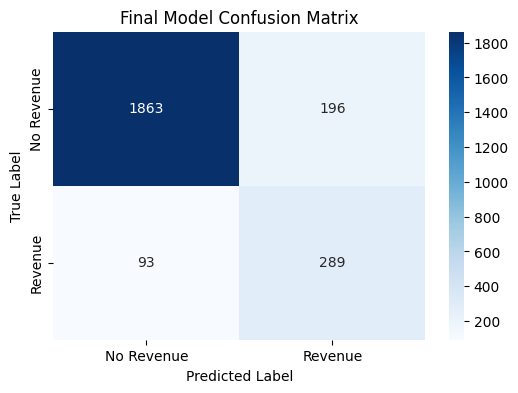


--- ROC Curve & AUC Score ---


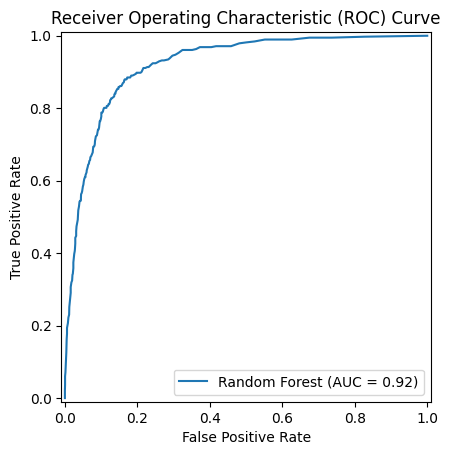

AUC Score: 0.9207


In [6]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1] 

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Revenue', 'Revenue']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Revenue', 'Revenue'],
            yticklabels=['No Revenue', 'Revenue'])
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("../reports/figures/final_model_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n--- ROC Curve & AUC Score ---")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.savefig("../reports/figures/final_model_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

## Feature Importance Analysis

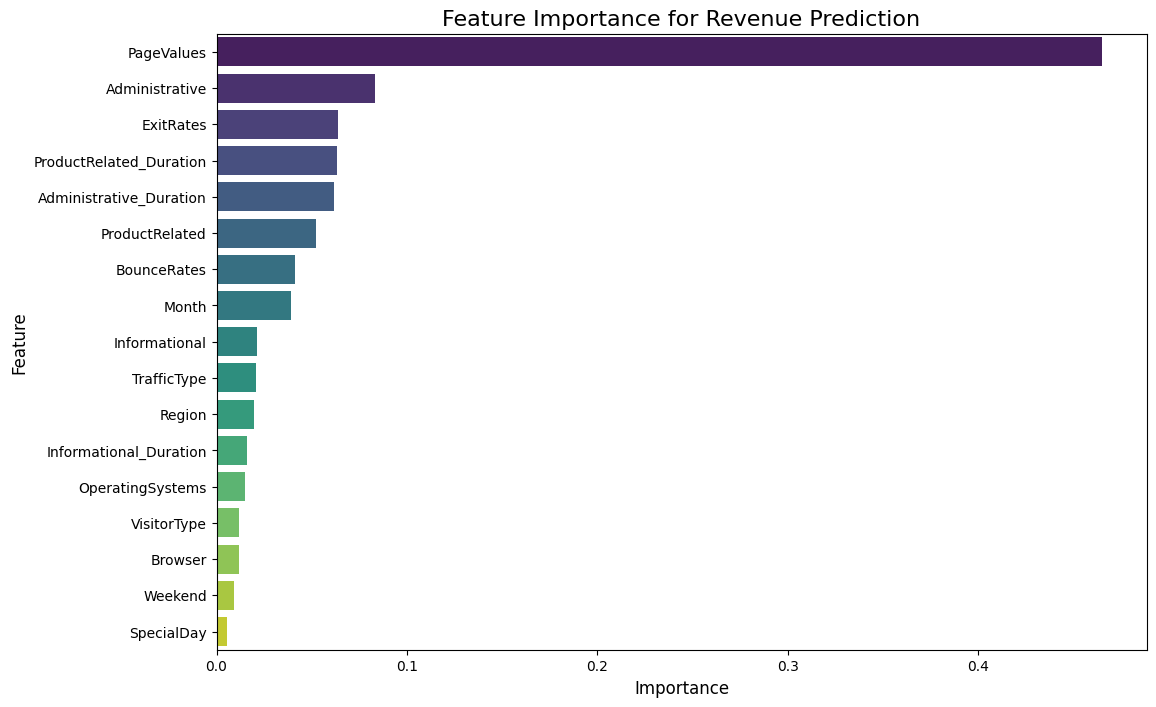


Top 5 Most Important Features:


,feature,importance
8,PageValues,0.465056
0,Administrative,0.083086
7,ExitRates,0.063865
5,ProductRelated_Duration,0.063496
1,Administrative_Duration,0.061750


In [10]:
importances = final_model.feature_importances_
feature_names = X_train_final.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Revenue Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.savefig("../reports/figures/Feature_importance_for_Revenue_Prediction.png", dpi=300, bbox_inches='tight')

plt.show()

print("\nTop 5 Most Important Features:")
feature_importance_df.head(5)

## Save Final Model Artifact

In [11]:
models_path = '../models/'
os.makedirs(models_path, exist_ok=True)

final_model_path = os.path.join(models_path, 'final_revenue_prediction_model.joblib')
joblib.dump(final_model, final_model_path)

print(f"\nFinal model successfully saved to: {final_model_path}")


Final model successfully saved to: ../models/final_revenue_prediction_model.joblib
